# Quark/gluon jet classification from CMS OpenData QCD Jets

## About the dataset

The dataset consists of particle jets extracted from 28614 proton-proton collision events at a COM energy of 13 TeV. This is a simulated dataset, i.e. the particles are constructed as PF (particle flow) candidates. The jets in this dataset were clustered from the PF candidates of each collision event using the anti-kt algorithm with distance parameter $R=0.4$. 
(Technicality: The standard $L_1+L_2+L_3$+residual jet energy corrections are applied to the jets and pileup contamination is mitigated using the charged hadron subtraction (CHS) algorithm.)

Filter criteria for jets: $p_T>30$ GeV and $\eta<2.5$. Features: those describing the jet on a high-level, particle-level and generator-level. There are also some features describing the collision event and the simulation conditions, for a total of 65 features + an event ID.

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/e5e0feec96154acc0ce2f8bf7ec19950b26a2522/10-Figure3-1.png", width=560)

A PYTHIA simulation of particles on a $\phi-\eta$ plane, with $\phi<3$ is shown above.

## Load the data set

We begin by importing a few essential libraries and then loading one of the data sets.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

The data set is available in two formats: ROOT and HDF5; we'll use the latter. The .h5 files can be read using the ``h5py`` package.

In [3]:
import h5py

# Load the HDF5 file
filePath = 'JetNtuple_RunIISummer16_13TeV_MC_1.h5'
h5File = h5py.File(filePath, 'r')
# Read-only

In [4]:
import pandas as pd

# Create and fill a dataframe
df = pd.DataFrame()
for key in h5File.keys():
    df[key] = h5File[key]

In [5]:
df.columns[:10]

Index(['PF_dEta', 'PF_dPhi', 'PF_dR', 'PF_dTheta', 'PF_fromAK4Jet',
       'PF_fromPV', 'PF_id', 'PF_mass', 'PF_pT', 'PV_npvsGood'],
      dtype='object')

Refer to http://opendata.cern.ch/record/12100 for detailed column descriptions.

In [6]:
df.shape
# There are 66 features for 28614 samples

(28614, 66)

### A note on the underlying physics

The machine learning example we present here is the __(binary) classification of jets originating either from gluons or one of the three lightest quarks__ (U,D and S). The accelerating partons radiate gluons, which can split into quark-antiquark pairs or radiate even more gluons. This chain reaction produces a shower of partons and they eventually form observable hadrons in a __cone-shaped cascade, called a jet__. The partons can interact in various interesting ways in the proton-proton collision and to understand these interaction processes, we need to be able to accurately classify the observed jets.

The (so-called) flavor of the jet is obtained from the generator-level particles by a jet flavor algorithm, which attempts to match a reconstructed jet to a single initiating particle. As a consequence, the jet flavor definition depends on the chosen algorithm: in ours, we look at the quarks (only U,D,S training data available) and gluons of the initial collision, which provide the training set labels. This is an important task, since on the observable macroscopic level the two types of jets look very similar, but from a physical point of view the difference between them is significant. The image below shows a PYTHIA simulation where quark(b,c,s)-jets and gluon(g)-jets are visible. There are also lepton jets, but we ignore them here for physical reasons.

In [9]:
Image(url= "http://research.hip.fi/swph/fig09/simulatedChHiggsDecay.gif", width=300)

### Preliminary data exploration

In [10]:
# Gluon, Quark (UDS) jet indicator, about 31% and 18% of jets
print("gluons:", df['isPhysG'].sum()/df.shape[0], ",","quarks:", df['isPhysUDS'].sum()/df.shape[0])

gluons: 0.30097155238694345 , quarks: 0.1852240162158384


Therefore, there isn't too much of a class imbalance in the dataset.

In [148]:
df.isnull().values.any()

False

There are no NaN entries in the dataset.

In [11]:
# Remove all the other types of jets from the data except the gluon/quark jets
df = df[(df.isPhysG==1) | (df.isPhysUDS==1)]#.reset_index()
df.shape

(13912, 66)

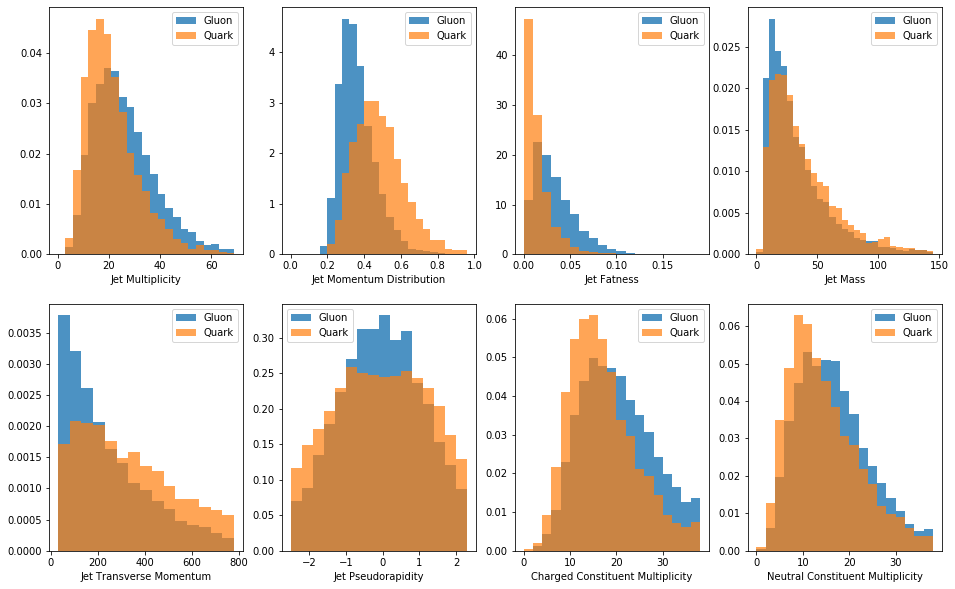

In [12]:
hist_columns = ['QG_mult','QG_ptD','QG_axis2','jetMass',
                'jetPt','jetEta','jetChargedMult','jetNeutralMult']
binnings = [np.arange(0,70,3), np.arange(0.0,1.0,0.04), np.arange(0.0,0.2,0.01),np.arange(0.0,150,5),
           np.arange(30,800,50),np.arange(-2.5,2.5,0.3),np.arange(0,40,2),np.arange(0,40,2)]
xlabellist=["Jet Multiplicity","Jet Momentum Distribution","Jet Fatness","Jet Mass",
            "Jet Transverse Momentum","Jet Pseudorapidity","Charged Constituent Multiplicity","Neutral Constituent Multiplicity"]
ind = 0
fig, axes = plt.subplots(2, 4, figsize=(16,10))
axes=axes.flatten()

for column in hist_columns:
    axes[ind].hist( df[df.isPhysG==1][column], bins=binnings[ind], alpha=0.8, label='Gluon', density=1 )
    axes[ind].hist( df[df.isPhysUDS==1][column], bins=binnings[ind], alpha=0.7, label='Quark', density=1 )
    axes[ind].set_xlabel(xlabellist[ind])
    axes[ind].legend()
    ind = ind+1

Some inferences are: __Jet multiplicity__ is the number of particles contained in the jet. Gluons are expected to radiate more intensely, so on average gluon jets contain more particles: also larger __Neutral and Charged Constuents__. Also, __Jet momentum distribution__ describes how the total transverse momentum of a jet is distributed to its constituents. Quark jets are expected to have fewer constituents carrying the majority of the jet's momentum. But also, gluon jets have less momentum and are more spread out, i.e. $\eta$ is small.

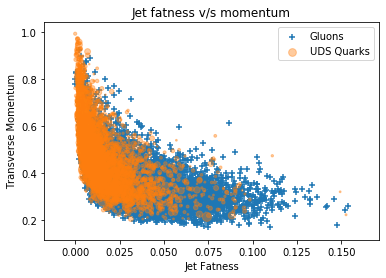

In [13]:
df1=df[df.isPhysG==1];
df2=df[df.isPhysUDS==1];
plt.scatter(df1['QG_axis2'],df1['QG_ptD'],marker="+",alpha=1,label="Gluons")
plt.scatter(df2['QG_axis2'],df2['QG_ptD'],s=df1['jetMass']/3,marker="o",alpha=0.4,label="UDS Quarks")
plt.xlabel('Jet Fatness')
plt.ylabel('Transverse Momentum')
plt.legend(loc="best")
plt.title('Jet fatness v/s momentum')
plt.show()

In [135]:
# From underlying physics

testable_features=[ 'PV_npvsGood','QG_axis2', 'QG_mult', 'QG_ptD', 'alpha','jetChargedMult',
       'jetEta', 'jetGirth', 'jetMass',  'jetPhi', 'jetPt', 'pthat','jetArea', 'jetMult', 'jetNeutralMult']

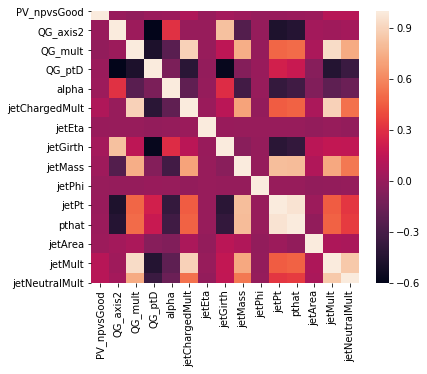

In [125]:
import seaborn as sns

corrMatrix = df[testable_features[:]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corrMatrix, annot=False)

### Data Preprocessing

In [137]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

train_y = train.isPhysUDS # binary
test_y = test.isPhysUDS

In [138]:
input_features = testable_features
train_x = train[input_features]
test_x = test[input_features]

In [139]:
# Normalize the features
train_x_mean = train_x.mean()
train_x_std = train_x.std()

train_x = (train_x - train_x_mean) / train_x_std
test_x = (test_x - train_x_mean) / train_x_std

In general, we would have to use a ``OneHotEncoder``, if the features had "ATLAS" or "ALICE" experiments written, but we don't have to worry about that here.

### Performance of Classification models

#### Naive-Bayes Classifier:

In [19]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(train_x,train_y)
model.score(train_x, train_y)

0.7475065145116363

In [20]:
# Cross-Validation score
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, train_x,train_y, cv=5)
cv_scores

array([0.75157233, 0.74663073, 0.75561545, 0.73989218, 0.73573034])

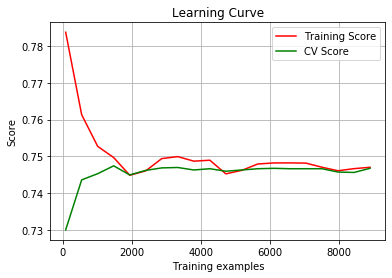

In [23]:
from sklearn.model_selection import learning_curve, ShuffleSplit

train_sizes, train_scores, cv_scores = learning_curve(GaussianNB(), 
                                            train_x, train_y, train_sizes=np.linspace(0.01, 1, 20),
                                            cv=ShuffleSplit(n_splits=4, test_size=0.2, random_state=42))

plt.grid()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.plot(train_sizes, train_scores.mean(1), '-', color="r",label="Training Score")
plt.plot(train_sizes, cv_scores.mean(1), '-', color="g",label="CV Score")
plt.legend(loc="best")
plt.show()

In [24]:
model.score(test_x, test_y)

0.7542220625224578

In [25]:
#F1, precision, recall score
from sklearn.metrics import f1_score,precision_score,recall_score
pred_y = model.predict(test_x)
print("F1 score =",f1_score(pred_y,test_y))
print("Precision =",precision_score(pred_y,test_y))
print("Recall =",recall_score(pred_y,test_y))

F1 score = 0.6812674743709226
Precision = 0.713170731707317
Recall = 0.6520963425512935


This can also be seen from the __confusion matrix__ below

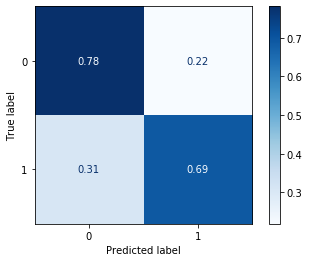

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, train_x, train_y,cmap=plt.cm.Blues,normalize='true')
plt.show()

This isn't very unexpected, since __most__ of the features are expected to be __quite__ statistically independent, from physical considerations! Also see correlation matrix above. Let's see if the remnant correlations are captured by Logistic Regression.

#### Logistic Regression:

In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_x,train_y)
model.score(train_x, train_y) 

0.7683529517476863

In [28]:
# Cross-Validation score
cv_scores = cross_val_score(model, train_x,train_y, cv=5)
cv_scores

array([0.76864331, 0.77583109, 0.76999102, 0.75651393, 0.76898876])

This looks good. Let's get the learning curve. We hope this works well!

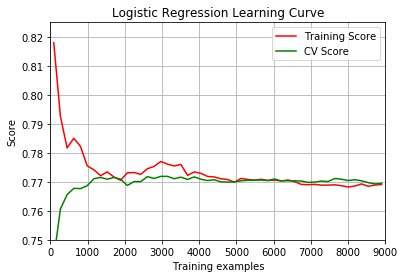

In [29]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

train_sizes, train_scores, cv_scores = learning_curve(LogisticRegression(), 
                                            train_x, train_y, train_sizes=np.linspace(0.01, 1, 50),
                                            cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=42))

plt.grid()
plt.ylim(0.75,0.825)
plt.xlim(0,9000)
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Logistic Regression Learning Curve")
plt.plot(train_sizes, train_scores.mean(1), '-', color="r",label="Training Score")
plt.plot(train_sizes, cv_scores.mean(1), '-', color="g",label="CV Score")
plt.legend(loc="best")
plt.show()

In [30]:
#R^2 score
model.score(test_x, test_y)

0.7800934243621991

In [31]:
#F1, precision, recall score
pred_y = model.predict(test_x)
print("F1 score =",f1_score(pred_y,test_y))
print("Precision =",precision_score(pred_y,test_y))
print("Recall =",recall_score(pred_y,test_y))

F1 score = 0.6851851851851852
Precision = 0.6497560975609756
Recall = 0.7247007616974973


Fine, almost as good as ``NaiveBayes`` actually, just a bit better. Let's try...

#### Support Vector Machine:

In [132]:
from sklearn.svm import SVC

svm_model = LogisticRegression()
svm_model.fit(train_x,train_y)
pred_y = svm_model.predict(test_x)

print("F1 score =",f1_score(pred_y,test_y))
print("Precision =",precision_score(pred_y,test_y))
print("Recall =",recall_score(pred_y,test_y))

F1 score = 0.6698014629049112
Precision = 0.6253658536585366
Recall = 0.7210348706411699


Not quite, and we don't expect the dataset to be linearly separable, so meh!

#### Decision Tree:

In [32]:
from sklearn import tree

for deep in range(1,10,1): 
    tree_model = tree.DecisionTreeClassifier(max_depth=deep)
    tree_model.fit(train_x,train_y)
    print("Depth is",deep,":",np.round(tree_model.score(train_x, train_y),3),"w/CV scores",
          np.round(cross_val_score(tree_model, train_x,train_y, cv=5),4))

Depth is 1 : 0.73 w/CV scores [0.7201 0.7314 0.7287 0.721  0.7294]
Depth is 2 : 0.737 w/CV scores [0.7264 0.7314 0.7314 0.7282 0.7294]
Depth is 3 : 0.75 w/CV scores [0.7381 0.7529 0.7484 0.7394 0.747 ]
Depth is 4 : 0.756 w/CV scores [0.7439 0.748  0.7538 0.7421 0.7474]
Depth is 5 : 0.766 w/CV scores [0.748  0.7507 0.7538 0.7376 0.751 ]
Depth is 6 : 0.777 w/CV scores [0.7412 0.739  0.7507 0.7426 0.7524]
Depth is 7 : 0.796 w/CV scores [0.7363 0.7403 0.7462 0.7435 0.7546]
Depth is 8 : 0.814 w/CV scores [0.7381 0.7305 0.7462 0.7264 0.747 ]
Depth is 9 : 0.831 w/CV scores [0.73   0.726  0.7251 0.7251 0.7474]


As the depth of the tree grows, it starts overfitting. We should probably use ``max_depth`` as 5.

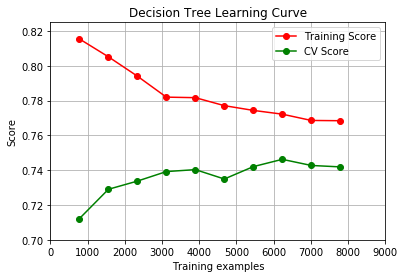

In [824]:
train_sizes, train_scores, cv_scores = learning_curve(tree.DecisionTreeClassifier(max_depth=5), 
                                            train_x, train_y, train_sizes=np.linspace(0.1, 1, 10),
                                            cv=ShuffleSplit(n_splits=4, test_size=0.3, random_state=42))

plt.grid()
plt.ylim(0.7,0.825)
plt.xlim(0,9000)
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Decision Tree Learning Curve")
plt.plot(train_sizes, train_scores.mean(1), '-o', color="r",label="Training Score")
plt.plot(train_sizes, cv_scores.mean(1), '-o', color="g",label="CV Score")
plt.legend(loc="best")
plt.show()

In [127]:
tree_model = tree.DecisionTreeClassifier(max_depth=5)

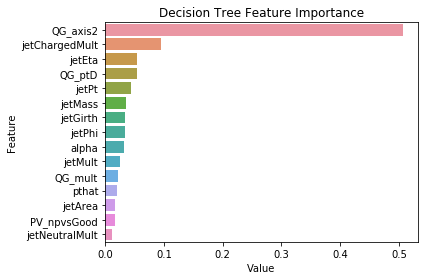

In [33]:
feature_importance = pd.DataFrame(sorted(zip(tree_model.feature_importances_, train_x.columns)), columns=['Value','Feature'])
plt.figure(figsize=(6, 4))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('Decision Tree Feature Importance')
plt.tight_layout()

In [128]:
tree_model.fit(train_x,train_y)
tree_model.score(test_x, test_y)

0.7549407114624506

In [129]:
#F1, precision, recall score
pred_y = tree_model.predict(test_x)
print("F1 score =",f1_score(pred_y,test_y))
print("Precision =",precision_score(pred_y,test_y))
print("Recall =",recall_score(pred_y,test_y))

F1 score = 0.6484536082474227
Precision = 0.6136585365853658
Recall = 0.687431693989071


``DecisionTreeClassifier`` gives slightly worse F1-performance than ``Logistic Regression``'s 0.68

#### Random Forest Classifier:

In [165]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators = 100,random_state = 42,max_features="sqrt")
rf_model.fit(train_x,train_y)
rf_model.score(train_x, train_y)

1.0

Woah! That's way too much overfitting with default parameters! We should play around with the number of trees in the forest (``n_estimators``) and ``max_depth``.

In [166]:
for deep in range(1,20,2): 
    rf_model = RandomForestClassifier(n_estimators = 400,random_state = 42,max_features=0.3,max_depth=deep)
    rf_model.fit(train_x,train_y)
    print("Depth is",deep,":",np.round(rf_model.score(train_x, train_y),3),"w/CV scores",
          np.round(cross_val_score(rf_model, train_x,train_y, cv=5),4))

Depth is 1 : 0.734 w/CV scores [0.7228 0.7444 0.73   0.7242 0.7335]
Depth is 3 : 0.756 w/CV scores [0.7417 0.7686 0.7507 0.7466 0.7533]
Depth is 5 : 0.768 w/CV scores [0.7489 0.7704 0.7628 0.7462 0.7533]
Depth is 7 : 0.784 w/CV scores [0.7529 0.7731 0.7633 0.7471 0.7578]
Depth is 9 : 0.818 w/CV scores [0.7552 0.7731 0.7659 0.7471 0.7569]
Depth is 11 : 0.862 w/CV scores [0.7552 0.7754 0.7695 0.7453 0.7569]
Depth is 13 : 0.913 w/CV scores [0.7597 0.7704 0.7633 0.7426 0.7667]
Depth is 15 : 0.952 w/CV scores [0.7529 0.7695 0.7646 0.7426 0.764 ]
Depth is 17 : 0.978 w/CV scores [0.757  0.7633 0.7628 0.7394 0.7631]
Depth is 19 : 0.996 w/CV scores [0.7516 0.7659 0.7615 0.7408 0.7631]


Looks good? Let's plot the learning curve with a cross-validation set 3-1

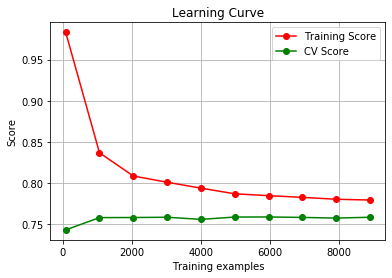

In [49]:
train_sizes, train_scores, cv_scores = learning_curve(RandomForestClassifier(n_estimators = 400,random_state = 42,
                                            max_features=0.3,max_depth=5), 
                                            train_x, train_y, train_sizes=np.linspace(0.01, 1, 10),
                                            cv=ShuffleSplit(n_splits=4, test_size=0.2, random_state=42))

plt.grid()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.plot(train_sizes, train_scores.mean(1), '-o', color="r",label="Training Score")
plt.plot(train_sizes, cv_scores.mean(1), '-o', color="g",label="CV Score")
plt.legend(loc="best")
plt.show()

In [50]:
rf_model = RandomForestClassifier(n_estimators = 400,random_state = 42,max_features=0.3,max_depth=5)
rf_model.fit(train_x,train_y)
rf_model.score(test_x, test_y)

0.7721882860222781

In [51]:
pred_y = rf_model.predict(test_x)
print("F1 score =",f1_score(pred_y,test_y))
print("Precision =",precision_score(pred_y,test_y))
print("Recall =",recall_score(pred_y,test_y))

F1 score = 0.656554712892741
Precision = 0.5912195121951219
Recall = 0.7381242387332522


``RandomForestClassifier`` gives slightly better performance than ``DecisionTreeClassifier`` but  ``Logistic Regression`` does better than that.

#### Extremely Randomized Trees Classifier:

In [38]:
from sklearn.ensemble import ExtraTreesClassifier

for deep in range(1,10,1): 
    et_model = ExtraTreesClassifier(n_estimators = 400,random_state = 42,max_features=0.3,max_depth=deep)
    et_model.fit(train_x,train_y)
    print("Depth is",deep,":",np.round(et_model.score(train_x, train_y),3),"w/CV scores",
          np.round(cross_val_score(et_model, train_x,train_y, cv=5),4))

Depth is 1 : 0.621 w/CV scores [0.6204 0.6204 0.6226 0.6226 0.6207]
Depth is 2 : 0.708 w/CV scores [0.7053 0.7098 0.7102 0.7049 0.7097]
Depth is 3 : 0.739 w/CV scores [0.7314 0.7462 0.7341 0.7345 0.7452]
Depth is 4 : 0.749 w/CV scores [0.7426 0.7588 0.743  0.7448 0.7524]
Depth is 5 : 0.756 w/CV scores [0.7471 0.7624 0.7534 0.7421 0.7569]
Depth is 6 : 0.76 w/CV scores [0.7525 0.7677 0.7579 0.7444 0.7613]
Depth is 7 : 0.768 w/CV scores [0.7552 0.7691 0.7588 0.7498 0.7596]
Depth is 8 : 0.777 w/CV scores [0.7552 0.7713 0.7637 0.7489 0.7627]
Depth is 9 : 0.789 w/CV scores [0.7565 0.7745 0.7668 0.7466 0.7622]


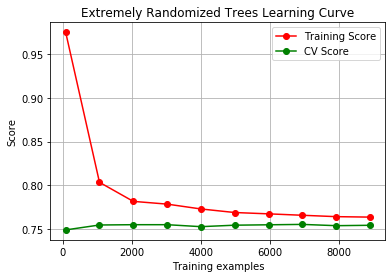

In [44]:
train_sizes, train_scores, cv_scores = learning_curve(ExtraTreesClassifier(n_estimators = 400,
                                            random_state = 42,max_features=0.3,max_depth=6), 
                                            train_x, train_y, train_sizes=np.linspace(0.01, 1, 10),
                                            cv=ShuffleSplit(n_splits=4, test_size=0.2, random_state=42))

plt.grid()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Extremely Randomized Trees Learning Curve")
plt.plot(train_sizes, train_scores.mean(1), '-o', color="r",label="Training Score")
plt.plot(train_sizes, cv_scores.mean(1), '-o', color="g",label="CV Score")
plt.legend(loc="best")
plt.show()

In [45]:
et_model = ExtraTreesClassifier(n_estimators = 400,random_state = 42,max_features=0.3,max_depth=5)
et_model.fit(train_x,train_y)
et_model.score(test_x, test_y)

0.7682357168523176

In [46]:
pred_y = et_model.predict(test_x)
print("F1 score =",f1_score(pred_y,test_y))
print("Precision =",precision_score(pred_y,test_y))
print("Recall =",recall_score(pred_y,test_y))

F1 score = 0.6256529309344167
Precision = 0.5258536585365854
Recall = 0.7722063037249284


### Comparison with results obtained by the CMS experiment

In the CMS collaboration, one typically uses the quark/gluon jet classifier or discriminator. The likelihood-product discriminator is a very simple approach, but also relatively robust and reliable. It assigns a value between zero and one as the __probability of a jet originating from a light quark__. This value is also contained in the data set for each jet in the __jetQGl__ column. Let's see how it looks.

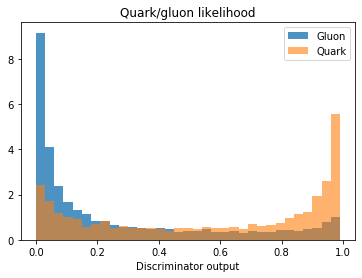

In [39]:
plt.clf()
binning = np.arange(0.0, 1.0, 0.03)
plt.hist( df[df.isPhysG==1]['jetQGl'], bins=binning, alpha=0.8, label='Gluon', density=1 )
plt.hist( df[df.isPhysUDS==1]['jetQGl'], bins=binning, alpha=0.6, label='Quark', density=1 )
plt.legend()
plt.xlabel('Discriminator output')
plt.title('Quark/gluon likelihood');

In [40]:
TP=sum(df[df.isPhysG==1]['jetQGl']<0.5)
FP=sum(df[df.isPhysG==0]['jetQGl']<0.5)
TN=sum(df[df.isPhysG==0]['jetQGl']>0.5)
FN=sum(df[df.isPhysG==1]['jetQGl']>0.5)
print(TP,FP,TN,FN)
print(TP+FP+TN+FN==df.shape[0]) # Just to be sure

precision=TP/(TP+FP)
recall=TP/(TP+FN)

6525 1692 3608 2087
True


In [41]:
print("F1 score=",2*precision*recall/(precision+recall))
print("Precision=",precision)
print("Recall=",recall)

F1 score= 0.7754471448095549
Precision= 0.7940854326396495
Recall= 0.7576637250348351


As can be seen, the discriminator at the LHC is much better than any other the individual methods described above, with an F1-score of 0.775. Our best is 0.68. This is not unexpected, since their models are way more complicated. Let's try to match (exceed?) it using deep learning methods

### Sequential DNN 

Target outputs for the DNN are the __isPhysUDS__ column, the value of which is one for light quark jets and zero for gluon jets.

In [141]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

train_y = train.isPhysUDS
test_y = test.isPhysUDS

Let's keep only a subset of these features; ``feature_importance`` of ``RandomForestClassifier`` guides us here.

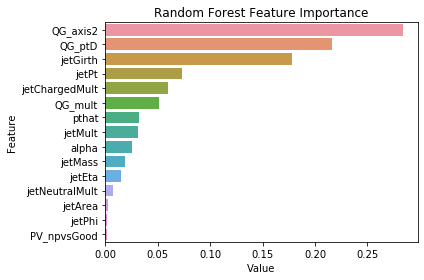

In [140]:
feature_importance = pd.DataFrame(sorted(zip(rf_model.feature_importances_, train_x.columns)), columns=['Value','Feature'])
plt.figure(figsize=(6, 4))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('Random Forest Feature Importance')
plt.tight_layout()

In [160]:
# let's pick the top 6
input_features=['QG_axis2','QG_ptD','jetGirth','jetPt','jetChargedMult','QG_mult']
train_x = train[input_features]
test_x = test[input_features]

# Normalize the features
train_x_mean = train_x.mean()
train_x_std = train_x.std()

train_x = (train_x - train_x_mean) / train_x_std
test_x = (test_x - train_x_mean) / train_x_std

Let us now build our neural network model. Please ensure compatibility with older versions of TF.

In [161]:
import tensorflow as tf
import keras.backend as K
sess = tf.compat.v1.Session() #compatibility
tf.compat.v1.keras.backend.set_session(sess)

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout
from sklearn.utils import class_weight

# Define the DNN architecture

# Linear stack of layers
model = Sequential()

# A regular densely-connected NN layer
model.add(Dense(30, kernel_initializer='normal', activation='relu', input_dim=train_x.shape[1]))
model.add(Dropout(0.2)) # Please GridSearch the hyperparameter choices

model.add(Dense(30, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

#model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_x,train_y,epochs=20,batch_size=100,validation_split=0.2,shuffle=True,verbose=2);

Train on 8903 samples, validate on 2226 samples
Epoch 1/20
 - 1s - loss: 0.5654 - accuracy: 0.7471 - val_loss: 0.5047 - val_accuracy: 0.7579
Epoch 2/20
 - 0s - loss: 0.5068 - accuracy: 0.7585 - val_loss: 0.4918 - val_accuracy: 0.7673
Epoch 3/20
 - 0s - loss: 0.5014 - accuracy: 0.7610 - val_loss: 0.4951 - val_accuracy: 0.7601
Epoch 4/20
 - 0s - loss: 0.5001 - accuracy: 0.7623 - val_loss: 0.4886 - val_accuracy: 0.7642
Epoch 5/20
 - 0s - loss: 0.5004 - accuracy: 0.7635 - val_loss: 0.4891 - val_accuracy: 0.7615
Epoch 6/20
 - 0s - loss: 0.4946 - accuracy: 0.7638 - val_loss: 0.4878 - val_accuracy: 0.7601
Epoch 7/20
 - 0s - loss: 0.4963 - accuracy: 0.7648 - val_loss: 0.4859 - val_accuracy: 0.7668
Epoch 8/20
 - 0s - loss: 0.4950 - accuracy: 0.7657 - val_loss: 0.4873 - val_accuracy: 0.7691
Epoch 9/20
 - 0s - loss: 0.4958 - accuracy: 0.7693 - val_loss: 0.4931 - val_accuracy: 0.7592
Epoch 10/20
 - 0s - loss: 0.4959 - accuracy: 0.7665 - val_loss: 0.4856 - val_accuracy: 0.7650
Epoch 11/20
 - 0s - l

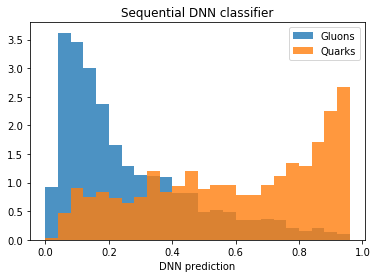

In [162]:
pred_y = model.predict(test_x)

plt.clf()
binning = np.arange(0.0, 1.0, 0.04)
plt.hist( pred_y[test_y==0], bins=binning, alpha=0.8, label="Gluons", density=1 )
plt.hist( pred_y[test_y==1], bins=binning, alpha=0.8, label="Quarks", density=1 )
plt.legend()
plt.xlabel('DNN prediction')
plt.title('Sequential DNN classifier');

In [163]:
np.array(model.get_weights()).shape

(6,)

In order to fairly compare our newly trained model and the traditional likelihood discriminator, we should look at the corresponding receiver operating characteristic (ROC) curves. The larger the area under the curve (AUC), the better the performance of the classifier.

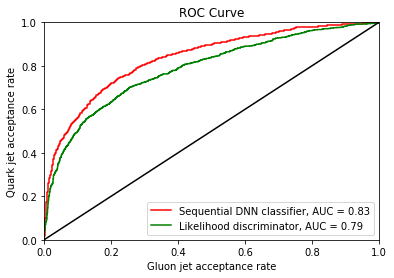

In [164]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr_dnn, tpr_dnn, thresholds_dnn  = roc_curve(test_y, pred_y)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

fpr_qgl, tpr_qgl, thresholds_qgl = roc_curve(test_y, test.jetQGl)
roc_auc_qgl = auc(fpr_qgl, tpr_qgl)

plt.clf()
plt.plot(fpr_dnn, tpr_dnn, 'r', label='Sequential DNN classifier, AUC = %0.2f'% roc_auc_dnn)
plt.plot(fpr_qgl, tpr_qgl, 'g', label='Likelihood discriminator, AUC = %0.2f'% roc_auc_qgl)
plt.plot([0,1], [0,1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 'best')
plt.title("ROC Curve")
plt.ylabel('Quark jet acceptance rate')
plt.xlabel('Gluon jet acceptance rate');

With higher ROC AUC value, we find that our newly trained classifier is better at the task in comparison to the likelihood discriminator.